# Imports

In [31]:
# Utils
from datetime import datetime
from datetime import timedelta
import os
import sys
import time
from itertools import combinations
from functools import partial

# Data management
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Data fetching
# !pip install yfinance
import yfinance as yf

# Spread generation
# from sklearn.linear_model import LinearRegression

In [32]:
_DAYS_IN_TRADING_YEAR = 252
_DAYS_IN_TRADING_MONTH = 21
_DAYS_IN_TRADING_WEEK = 5

# Utils

## Stonk price data download

### Input ticker names by industry

In [33]:
def get_tickers_by_industry(market_cap_min_mm, market_cap_max_mm, industries, data_dir=None, filename=None):
    '''
    Read the CSV file containing all tickers and their subindustries and return tickers from the selected subindustries in a list.
    
    -Args:
        industries (List(string)): if not given, return all tickers.
    -Returns:
        tickers (pandas Series): list of selected ticker names
    '''
    filename = 'stonk_list.csv' if filename is None else filename
    data_dir = 'data' if data_dir is None else data_dir
    
    if not market_cap_max_mm:
        market_cap_max_mm = np.iinfo(np.int32).max
    
    path_to_csv = os.path.join(data_dir, filename)
    stonk_list = pd.read_csv(path_to_csv)
    stonk_list = stonk_list[stonk_list['market_cap'].between(market_cap_min_mm, market_cap_max_mm)]
    return stonk_list.set_index('ticker') if not industries else stonk_list[stonk_list['subindustry'].isin(industries)].set_index('ticker')

In [65]:
def download_stonk_prices(stonk_list, period_years, date_from=None, date_to=None, interval='1d', source='yfinance', data_dir='data', proxy=False):    
    '''
    Returns historical price data for the selected stonks.

    -Args:
        stonk_list (List(string)): List of stonk identifiers as strings, case unsensitive
        period_years (float): How many years of data to download until date_to, can be a floating point number
    -Optional:
        date_from (datetime): Start date for stonk data (use instead of period_years)
        date_to (datetime): End date for stonk data
        interval (string): Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        source (string): Where to source data from. Valid sources: yfinance
        data_dir (string): Folder name where to output downloaded data
        file_prefix (string): Prefix of CSV file containing downloaded data inside data_dir
        proxy (boolean): Whether to use a proxy connection to avoid API limits/blocks
                
    -Returns:
        stonks (Pandas Dataframe): Pandas Dataframe containing requested ticker prices
    '''
    
    date_to = datetime.now() if date_to is None else date_to
    date_from = date_to-(timedelta(days=int(365*period_years))) if date_from is None else date_from
    
    if source.lower() == 'yfinance':
        stonks = yf.download(list(stonk_list), start=date_from, end=date_to, interval=interval, group_by='column', threads=True, rounding=True)['Adj Close']
        stonks.dropna(axis=0, how='all', inplace=True)
        stonks.sort_values(by='Date', inplace=True)
        
        stonks.index = pd.to_datetime(stonks.index).date
        stonks.index.name = 'date'

        clean_stonks = stonks.dropna(axis=1, how='all', thresh=int(len(stonks.index) * 0.99)).copy()
        clean_stonks.dropna(axis=0, how='all', thresh=int(len(clean_stonks.columns) * 0.99), inplace=True)
        
        # Forward fill ticker columns (axis=0 for columns)
        clean_stonks.fillna(axis=0, method='ffill', inplace=True)
        
        clean_stonks.dropna(axis=1, how='any', inplace=True)
        
        # Must be no NA values left
        assert clean_stonks.isna().sum().sum() == 0
    else:
        raise ValueError('Unsupported data source')
        
    def stonks_to_csv(stonks, clean):
        from_date_string = stonks.index[0]
        to_date_string = stonks.index[-1]

        filename = 'stonks_{from_date}_to_{to_date}.csv'.format(from_date=from_date_string, to_date=to_date_string)
        
        if clean:
            filename = 'clean_' + filename
            
        file_path = os.path.join(data_dir, filename)

        stonks.to_csv(path_or_buf=file_path, header=True, index=True, na_rep='NaN')
    
    stonks_to_csv(stonks, clean=False)
    stonks_to_csv(clean_stonks, clean=True)
    
    return (stonks, clean_stonks)

## Stock price data input

In [35]:
def read_stonk_data(date_from, date_to, clean=True, date_index=False, data_dir=None):
    data_dir = 'data' if data_dir is None else data_dir
    data_prefix = 'clean_stonks' if clean else 'stonks'
    
    path = os.path.join(data_dir, '{}_{}_to_{}.csv'.format(data_prefix, date_from, date_to))
    stonks = pd.read_csv(path, header=0, index_col=0).astype(np.float32)
    
    if clean:
        assert stonks.isna().sum().sum() == 0
    
    if date_index:
        return stonks
    else:
        return stonks.T

In [64]:
def get_stonk_data_by_industry(date_from, date_to, market_cap_min_mm=1000, market_cap_max_mm=None, clean=True, date_index=False, industries=None, stonk_list_filename=None, data_dir=None):
    '''
    Read the CSV file containing all stonk price data and return the tickers from the selected subindustries.
    
    -Args:
        industries (List(string)): if not given, return all tickers
    
    -Returns:
        stonks (pandas DataFrame): list of selected tickers' price data
    '''
    all_stonks = read_stonk_data(date_from, date_to, date_index=date_index, data_dir=data_dir, clean=clean)
    selected_tickers = get_tickers_by_industry(market_cap_min_mm=market_cap_min_mm, market_cap_max_mm=market_cap_max_mm, industries=industries, data_dir=data_dir, filename=stonk_list_filename)
    return all_stonks[all_stonks.index.isin(selected_tickers.index)]

In [37]:
# TODO: make combinations with numpy
def combine_stonk_pairs(stonks_prices):
    # All ticker names must be unique
    assert all(stonks_prices.index.unique() == stonks_prices.index)
    
    # Check that there isn't too many combinations
    assert(len(stonks_prices) < 400)
    
    combs = np.asarray(list(combinations(stonks_prices.index.unique(), 2)))
    
    return stonks_prices.loc[combs[:, 0]], stonks_prices.loc[combs[:, 1]]

## Linear regression residuals

In [38]:
def get_residuals_many(X, Y):
    '''
    Vectorized calculation of residuals from many univariate linear regressions.
        Args:
        - X (numpy array of shape (n_pairs, d_time)): matrix of LR inputs X, each row represents a different regression, corresponding to the same rows in Y
        - Y (numpy array of shape (n_pairs, d_time)): matrix of LR inputs Y, each row represents a different regression, corresponding to the same rows in X
        Returns:
        - residuals (numpy array of shape (n_pairs, d_time)): matrix of resulting residuals between vectorized pairs of X and Y
        - betas (numpy array of shape (n_pairs, 1)): beta coefficients for each linear regression
        - Y_hat (numpy array of shape (n_pairs, d_time)): predictions using X
    '''
    # Stack 2D matrices into 3D matrices
    X = X.reshape(np.shape(X)[0], np.shape(X)[1], -1).astype(np.float32)
    Y = Y.reshape(np.shape(Y)[0], np.shape(Y)[1], -1).astype(np.float32)
    
    # Add bias/intercept in the form (Xi, 1)
    Z = np.concatenate([X, np.ones((np.shape(X)[0], np.shape(X)[1], 1), dtype=np.float32)], axis=2)
    del X
    
    # Save the transpose as it's used a couple of times
    Z_t = Z.transpose(0, 2, 1)
    
    # Linear Regression equation solutions w.r.t. weight matrix
    # W contains (beta_coef, a_intercept) for each regression
    W = np.matmul(np.linalg.inv(np.matmul(Z_t, Z)),  np.matmul(Z_t, Y))
    del Z_t
    
    # Predictions and residuals
    # Y_hat = np.matmul(Z, W).round(2)
    residuals = (Y - np.matmul(Z, W)).round(2)
    del Y
    del Z
    assert residuals.dtype == np.float32
    
    # Y_hat returned for debugging purposes
    # return (residuals[:, :, 0], W[:, 0, 0], Y_hat[:, :, 0])
    return (residuals[:, :, 0], W[:, 0, 0],  W[:, 1, 0])

In [39]:
def get_rolling_residuals(X, Y, l_reg, l_roll, dt):
    '''
    Calculates rolling window residuals in vectorized form. Returns the result as an array that repeats each ticker for the number of regressions calculated.
    For example, if the inputs are (Pair A, Pair B, Pair C) and l_roll / dt = 3, then the returned results will have the form as follows:
    (Pair A, Pair A, Pair A, Pair B, Pair B, Pair B, Pair C, Pair C, Pair C)
    Works best when l_reg and l_roll are integers.
        Args:
        - X, Y (DataFrame of shape (n_pairs, >= l_reg + l_roll)): matrix of LR inputs X, Y; each row containing at least the complete data period for rolling regressions (can be longer)
        - l_reg (float): length of each LR to calculate residuals, in years; will be multiplied by the adjusted number of days in a trading year
        - l_roll (float): length of rolling window, in years; will be multipled by the adjusted number of days in a trading year
        - dt (int): rolling window step size, in trading days; total trading year days will be reduced to be divisible by dt (by not more than the value of dt)
        Returns:
        - residuals (numpy array of shape (n_pairs * (l_roll/dt)+1, l_reg + l_roll)): matrix of resulting residuals between vectorized pairs of X and Y
        - betas (numpy array of shape (n_pairs * (l_roll/dt)+1, 1)): beta coefficients for each linear regression
        - Y_hat (numpy array of shape (n_pairs * (l_roll/dt)+1, l_reg + l_roll)): predictions using X
    '''
    
    # Adjust days so that they are divisible by dt
    l_reg_days = int(_DAYS_IN_TRADING_YEAR * l_reg)
    l_reg_days-= l_reg_days % dt
    l_roll_days = int(_DAYS_IN_TRADING_YEAR * l_roll)
    l_roll_days-= l_roll_days % dt
    
    total_days = l_reg_days + l_roll_days
    
    # Number of regressions for each ticker
    n_windows = (l_roll_days // dt) + 1
    
    # Number of tickers
    n_x = X.shape[0]
    
    # Take the dates, create an empty array for windowed dates
    date_index = X.columns[-total_days:]
    date_index_windowed = np.empty(shape=(n_x*n_windows, 2), dtype='O')
    
    # Repeat each ticker name times n_windows
    X_index = np.repeat(X.index, n_windows)
    Y_index = np.repeat(Y.index, n_windows)
    
    # X and Y must have the same dates
    assert np.array_equal(X.columns, Y.columns)
    
    X = X.to_numpy(dtype=np.float32)
    Y = Y.to_numpy(dtype=np.float32)
    
    # Rolling window length must be divisible by dt
    assert (l_roll_days % dt) == 0
    
    # There has to be enough days' worth of data in X (and Y) and their shapes must match
    assert X.shape == Y.shape and X.shape[1] >= total_days
    
    # Take the total_days from the end of the arrays (most recent days first, oldest days at the end are cut off)
    X = X[:, -total_days:]
    Y = Y[:, -total_days:]
    
    # Create empty arrays that will contain windowed slices of our data
    X_windows = np.empty(shape=(n_x*n_windows, l_reg_days))
    Y_windows = np.empty(shape=(n_x*n_windows, l_reg_days))
    
    # Take windowed slices and place them into the created empty arrays
    for n in range(n_x):
        for i in range(n_windows):
            n_i = (n*n_windows)+i
            t_i = i*dt
            t_y = t_i + l_reg_days
            
            X_windows[n_i] = X[n, t_i:t_y]
            Y_windows[n_i] = Y[n, t_i:t_y]
            date_index_windowed[n_i, 0] = date_index[t_i]
            date_index_windowed[n_i, 1] = date_index[t_y-1]
    
    # Make sure we've got the windowing dimensions right
    assert X_windows.shape == (n_x*n_windows, l_reg_days) and Y_windows.shape == (n_x*n_windows, l_reg_days)
    
    # Sanity checks
    assert all([
        X[0, -1] == X_windows[n_windows-1, -1],
        Y[0, -1] == Y_windows[n_windows-1, -1],
        X[-1, -1] == X_windows[-1, -1],
        Y[-1, -1] == Y_windows[-1, -1],
    ])
    
    # Construct ticker pair index column
    pair_index = np.array(pd.DataFrame(np.array([Y_index, X_index])).apply('_'.join, axis=0, raw=True))
    
    # Construct regression date range index column
    date_index = np.array(pd.DataFrame(np.array([date_index_windowed[:, 0], date_index_windowed[:, 1]])).apply('_'.join, axis=0, raw=True))
    
    # Lengths of indexes must match
    assert len(pair_index) == len(date_index)
    
    # Calculate and return the residuals
    res, betas, intercepts = get_residuals_many(X_windows, Y_windows)
    
    res = pd.DataFrame(res, index=pair_index)
    res.insert(0, 'dates', date_index)
    
    betas = pd.DataFrame(betas, index=pair_index)
    betas.insert(0, 'dates', date_index)
    
    intercepts = pd.DataFrame(intercepts, index=pair_index)
    
    return res, betas, intercepts

## ADF testing

In [40]:
def get_adfs(residuals, adf_regression):
    # Get ADF test p-values for each row of the residuals array. No autolag (maxlag always used)
    assert residuals.dtype == np.float32
    return np.apply_along_axis(lambda x: adfuller(x, regression=adf_regression, autolag=None)[1], axis=1, arr=residuals)

In [41]:
def get_aggregate_adfs(residuals, betas=None, cutoff=0.1, adf_regression='c'):
    # Get ADF p-values
    adfs = get_adfs(residuals.drop(columns='dates').to_numpy(dtype=np.float32), adf_regression=adf_regression).reshape((-1, 1))
    
    # Add ones to ADF values where betas are negative, if betas are given
    if betas is not None:
        # Must be the same number of columns
        assert adfs.shape[0] == betas.shape[0]
        # Residuals and betas must have the same index names
        assert np.all(residuals.index == betas.index)
        # Add 1's to p-values where betas are negative
        adfs = adfs + (betas[0].to_numpy() <= 0).reshape((-1, 1))
        
    # Make a copy for returning, CSV output
    adfs_raw = pd.DataFrame(adfs.copy(), index=residuals.index)
    
    # All unique ticker pairs, in original order
    unique_pairs = residuals.index.unique()
    
    # Number of regressions for one pair
    pairs_per_index = len(residuals) // len(unique_pairs)
    
    # Reshape into a 3D array for averaging ADF values along the second axis
    adfs = adfs.reshape((len(unique_pairs), pairs_per_index, 1))
    
    # Takes cutoff, averages along the pairs_per_index (second) axis
    adfs = (adfs <= cutoff).mean(axis=1)
    
    # Probably always true, but just in case
    assert adfs.shape[0] == len(unique_pairs)
        
    # Back to a DataFrame with named indexes
    adfs = pd.DataFrame(adfs, index=unique_pairs)
        
    return adfs, adfs_raw

## Standardized residuals

In [42]:
def get_last_pairs(pairs):
    # Get unique ticker pairs, in preserved order
    unique_pairs = pairs.index.unique()
    
    # Number of samples per ticker pair
    pairs_per_index = len(pairs) // len(unique_pairs)
    
    # Must be an equal number of pairs per index
    assert pairs_per_index * len(unique_pairs) == len(pairs)
    
    # Slice taking only the last regression for each ticker pair
    last_pairs = pairs.iloc[pairs_per_index-1:len(pairs):pairs_per_index].copy()
    
    # Make sure we got the slices right
    assert np.all(last_pairs.index == unique_pairs) and np.all(pairs.iloc[-1] == last_pairs.iloc[-1])
        
    return last_pairs

In [43]:
def get_standardized_residuals(residuals):
    # Dates aren't needed anymore, as we're using the latest regressions
    residuals = residuals.drop(columns='dates')
    
    # Get the last regression for each spread
    last_reg_pairs = get_last_pairs(residuals)
    
    # Get unique ticker pairs
    unique_pairs = last_reg_pairs.index
    
    # Convert to numpy
    last_reg_pairs = last_reg_pairs.to_numpy(dtype=np.float32)
    
    # Standardize
    means = last_reg_pairs.mean(axis=1, keepdims=True)
    stds = last_reg_pairs.std(axis=1, keepdims=True)
    last_reg_pairs = (last_reg_pairs - means) / stds
    
    # Back to a DataFrame with named indexes
    last_reg_pairs = pd.DataFrame(last_reg_pairs, index=unique_pairs)
    means = pd.DataFrame(means, index=unique_pairs)
    stds = pd.DataFrame(stds, index=unique_pairs)
        
    return (last_reg_pairs, means, stds)

## Mean residual magnitude

In [44]:
def get_mean_residual_magnitude(std_residuals, dt):
    # Assume there is enough days' worth of data for averaging over dt days
    assert std_residuals.shape[1] >= dt
    
    # Select the last dt days from the right
    std_residuals = std_residuals.to_numpy(dtype=np.float32)[:, -dt:]
    
    # Take the absolute maximum for each day, over all tickers, mean over the results
    mean_magnitude = np.round(np.abs(std_residuals).max(axis=0).mean(), 2)
    
    return mean_magnitude

## Trade returns and future residuals calculations

In [45]:
def get_trades_returns(prices_X, prices_Y, betas_YX, buy_X):

    # Save spread indexes for later
    pairs_indexes = betas_YX.index.copy()
    
    # Take numpy betas
    betas_YX = betas_YX.drop(columns='dates').to_numpy().copy()

    # Take numpy buy list for X
    buy_X = buy_X.values.copy()

    # Sanity checks
    assert all([
        prices_X.shape == prices_Y.shape,
        len(buy_X) == betas_YX.shape[0]
    ])

    # Prices to numpy
    prices_X = prices_X.to_numpy().copy()
    prices_Y = prices_Y.to_numpy().copy()

    # Save entering prices at t=0
    initial_prices_X = prices_X[:, [0]].copy()
    initial_prices_Y = prices_Y[:, [0]].copy()

    # Initial proportional values of trades at t=0, X prices scaled by beta
    initial_trade_values = (initial_prices_X * betas_YX) + initial_prices_Y

    # Returns for X, Y trades each day. X prices scaled by beta
    returns_X = betas_YX * (prices_X - initial_prices_X)
    returns_Y = prices_Y - initial_prices_Y

    # Negate short trades
    returns_X[~buy_X] = -returns_X[~buy_X]
    returns_Y[buy_X] = -returns_Y[buy_X]

    # Add the trade returns for X, Y, divide by initial investment values to get profit/loss %
    trade_returns = ((returns_X + returns_Y) / initial_trade_values).round(3)

    # Back to dataframe with indexes
    trade_returns = pd.DataFrame(trade_returns, index=pairs_indexes)
    
    return trade_returns

In [46]:
def get_trades_residuals(prices_X, prices_Y, betas_YX, intercepts_YX, means_YX, stds_YX):

    # Sanity checks
    assert all([
        np.all(betas_YX.index == intercepts_YX.index),
        np.all(means_YX.index == stds_YX.index),
        np.all(betas_YX.index == stds_YX.index)
    ])
    
    # Save indexes for later
    indexes = betas_YX.index.copy()
    
    betas_YX = betas_YX.drop(columns='dates').to_numpy().copy()
    intercepts_YX = intercepts_YX.to_numpy().copy()
    
    means_YX = means_YX.to_numpy().copy()
    stds_YX = stds_YX.to_numpy().copy()
    
    prices_X = prices_X.to_numpy().copy()
    prices_Y = prices_Y.to_numpy().copy()

    # Sanity checks
    assert all([
        prices_X.shape == prices_Y.shape,
        betas_YX.shape[0] == intercepts_YX.shape[0] == means_YX.shape[0] == stds_YX.shape[0] == prices_X.shape[0],
        betas_YX.shape[1] == intercepts_YX.shape[1] == means_YX.shape[1] == stds_YX.shape[1] == 1,
    ])
    
    # Calculate residuals from regression form: Y = bX + a
    trade_residuals = prices_Y - ((betas_YX * prices_X) + intercepts_YX)
    
    # Standardize the residuals
    trade_residuals = ((trade_residuals - means_YX) / stds_YX).round(2)

    # Back to dataframe with indexes
    trade_residuals = pd.DataFrame(trade_residuals, index=indexes)
    
    return trade_residuals

## Data collection pipeline

In [47]:
def data_collection_rolling_pipeline(stonk_prices, industries, l_reg, l_roll, dt, market_cap_min_mm=1000, adf_pval_cutoff=0.1, adf_pass_rate_filter=0.5, trade_length_months=3, trading_interval_weeks=4, data_dir='data'):
    _DAYS_IN_TRADING_YEAR = 252
    
    # Adjust days so that they are divisible by dt
    l_reg_days = int(_DAYS_IN_TRADING_YEAR * l_reg)
    l_reg_days-= l_reg_days % dt
    l_roll_days = int(_DAYS_IN_TRADING_YEAR * l_roll)
    l_roll_days-= l_roll_days % dt
    
    total_days = l_reg_days + l_roll_days
    trade_length_days = _DAYS_IN_TRADING_MONTH * trade_length_months
    trading_interval_days = _DAYS_IN_TRADING_WEEK * trading_interval_weeks
    total_backtest_days = total_days + trade_length_days
    
    # Get tickers from selected industries
    tickers = get_tickers_by_industry(market_cap_min_mm, industries, data_dir=data_dir)
    
    data_range = range(stonk_prices.shape[1], total_backtest_days, -trading_interval_days)
    
    total_data_windows = len(list(data_range))
    total_industries = len(industries)
    
    print('Total data windows: ' + str(total_data_windows))
    
    for index_end in data_range:
        index_start = index_end - total_backtest_days
        data_window = stonk_prices.iloc[:, index_start:index_end]
        assert data_window.shape[1] == total_backtest_days
        
        print('Period ' + str(data_window.columns[0]) + ' to ' +  str(data_window.columns[-1]))
        
        data_all_industries = []
        for industry in industries:
            tickers_by_industry = tickers[tickers['subindustry'] == industry]
            data_window_by_industry = data_window[data_window.index.isin(tickers_by_industry.index)]
            X, Y = combine_stonk_pairs(data_window_by_industry)
            
            data = pd.DataFrame(data_collection_step(X, Y, l_reg, l_roll, dt, adf_pval_cutoff, adf_pass_rate_filter, trade_length_months))
            
            data['data_window_start'] = np.full(data.shape[0], X.columns[0])
            data['subindustry'] = np.full(data.shape[0], industry)
            
            data_all_industries.append(data)
            
            print('Industries ' + str(len(data_all_industries)) + '/' + str(total_industries))
        
        data_all_industries = pd.concat(data_all_industries, ignore_index=True)
        
        filename = '_'.join([
            str(data_window.columns[0]),
            str(data_window.columns[-1]),
            str(l_reg),
            str(l_roll),
            str(dt),
            str(market_cap_min_mm),
            str(adf_pval_cutoff),
            str(adf_pass_rate_filter)
        ]) + '.csv'
        
        data_output_path = os.path.join(data_dir, 'trades', filename)
        
        data_all_industries.to_csv(data_output_path, header=True, index=False)
        
        total_data_windows-= 1
        print('Remaining data windows: ' + total_data_windows)

### Data collection pipeline step

In [48]:
def data_collection_step(X, Y, l_reg, l_roll, dt, adf_pval_cutoff, adf_pass_rate_filter, trade_length_months):
    assert X.shape == Y.shape

    _DAYS_IN_TRADING_MONTH = 21
    output = {}

    trade_length_days = trade_length_months*_DAYS_IN_TRADING_MONTH

    X_until_T = X.iloc[:, :-trade_length_days].copy()
    Y_until_T = Y.iloc[:, :-trade_length_days].copy()

    X_from_T = X.iloc[:, -trade_length_days-1:].reset_index().drop_duplicates(subset='index').set_index('index').copy()
    Y_from_T = Y.iloc[:, -trade_length_days-1:].reset_index().drop_duplicates(subset='index').set_index('index').copy()

    # X and Y dimensions must match
    assert X_from_T.shape == Y_from_T.shape and X_until_T.shape == Y_until_T.shape

    # Check whether enough days' worth of data was given
    assert X_from_T.shape[1] == trade_length_days+1 and X.shape[1] == X_until_T.shape[1] + X_from_T.shape[1] - 1
    
    del X
    del Y

    residuals, betas, intercepts = get_rolling_residuals(X=X_until_T, Y=Y_until_T, l_reg=l_reg, l_roll=l_roll, dt=dt)
    std_residuals, means, stds = get_standardized_residuals(residuals)
    
    # Filter residuals to only select relevant trades that fit the theoretical assumptions
    std_residuals = std_residuals[std_residuals.iloc[:, -1].abs() >= 2]
    
    if len(std_residuals) == 0:
        return {}
    
    residuals = residuals.loc[std_residuals.index]
    betas = betas.loc[std_residuals.index]
    intercepts = intercepts.loc[std_residuals.index]
    
    adfs, adfs_raw = get_aggregate_adfs(residuals, betas=betas, cutoff=adf_pval_cutoff)
    del adfs_raw

    # Select betas and intercepts from the most recent regressions
    betas = get_last_pairs(betas)
    intercepts = get_last_pairs(intercepts)

    assert np.all(std_residuals.index == betas.index)
    assert np.all(adfs.index == std_residuals.index)
    assert np.all(intercepts.index == betas.index)

    # Select trades that are above the specified ADF pass rate
    selected_by_adf = (adfs >= adf_pass_rate_filter).values

    std_residuals = std_residuals[selected_by_adf]
    
    if len(std_residuals) == 0:
        return {}

    residuals_max_mean = get_mean_residual_magnitude(std_residuals, dt=21)

    betas = betas.loc[std_residuals.index]
    intercepts = intercepts.loc[std_residuals.index]
    
    means = means.loc[std_residuals.index]
    stds = stds.loc[std_residuals.index]

    # True for trades where we buy X and short Y
    buys_X = std_residuals.iloc[:, -1] > 0

    trades_tickers = separate_pair_index(std_residuals.index)
    X_from_T = X_from_T.loc[trades_tickers['x']]
    Y_from_T = Y_from_T.loc[trades_tickers['y']]

    trade_returns = get_trades_returns(prices_X=X_from_T, prices_Y=Y_from_T, betas_YX=betas, buy_X=buys_X)
    trade_residuals = get_trades_residuals(prices_X=X_from_T, prices_Y=Y_from_T, betas_YX=betas, intercepts_YX=intercepts, means_YX=means, stds_YX=stds)

    output_length = len(std_residuals)
    output['ticker_x'] = X_from_T.index
    output['ticker_y'] = Y_from_T.index
    output['trade_date'] = np.full(output_length, X_from_T.columns[0])
    
    output['adf_pass_rate'] = adfs[selected_by_adf][0].values.round(2)
    output['last_residual'] = std_residuals.iloc[:, -1].values.round(2)
    output['beta'] = betas[0].values.round(2)
    output['intercept'] = intercepts[0].values.round(2)
    output['residual_mean_max'] = np.full(output_length, residuals_max_mean)

    output['return_one_month'] = trade_returns.iloc[:, 21].values
    output['residual_one_month'] = trade_residuals.iloc[:, 21].values
    if trade_length_months > 1:
        output['return_two_month'] = trade_returns.iloc[:, 42].values
        output['residual_two_month'] = trade_residuals.iloc[:, 42].values
    else:
        output['return_two_month'] = np.full(output_length, np.nan)
        output['residual_two_month'] = np.full(output_length, np.nan)

    if trade_length_months > 2:
        output['return_three_month'] = trade_returns.iloc[:, 63].values
        output['residual_three_month'] = trade_residuals.iloc[:, 63].values
    else:
        output['return_three_month'] = np.full(output_length, np.nan)
        output['residual_three_month'] = np.full(output_length, np.nan)


    return output

In [49]:
def ingest_trade_data(data_dir='data/trades'):
    data_list = []
    for file in os.listdir(data_dir):
            if file.endswith('csv'):
                data_list.append(pd.read_csv(os.path.join(data_dir, file)))
    df = pd.concat(data_list, ignore_index=True)
    return df

## Other

### Utility functions

In [50]:
def measure_time(func):
    t1 = time.time()
    ret = func()
    t2 = time.time()
    print("Done after: " + str(int(t2-t1)) + 's')
    return ret

In [51]:
def separate_pair_index(indexes):
    indexes = pd.Series(indexes)
    splits = indexes.apply(lambda x: pd.Series(x.split('_')))
    y = splits[0].values
    x = splits[1].values
    return {'y':y, 'x':x}

## Pipeline example tutorial

#### 0. Import tickers from given custom list

In [19]:
# filename = 'data/selected_spreads.csv'
# ticker_pairs = pd.read_csv(filename, header=0)
# ticker_pairs.set_index('spreads', inplace=True)

# separated_indexes = separate_pair_index(ticker_pairs.index)
# ticker_pairs['x'] = separated_indexes['x']
# ticker_pairs['y'] = separated_indexes['y']

# ticker_pairs = ticker_pairs.loc[~ticker_pairs.index.str.contains(r'CIT|LORL|ENBL|MDP')]

#### 1. Download stock daily prices

In [60]:
# Gets all ticker names (no argument given)
ticker_list = get_tickers_by_industry(market_cap_min_mm=1000, market_cap_max_mm=None, industries=[])

In [20]:
# ticker_list = set(list(ticker_pairs['x']) + list(ticker_pairs['y']))

In [57]:
# Specific date - 3rd of March 2022 (Y, M, D)
# date_to = datetime(2022, 3, 1)
# Date of today
date_to = datetime.today()
# How many years' of data to download (going backwards from date_end). Year can be a floating point number
period_years = 5

In [58]:
# Download ticker price data for the tickers selected above (saved to .csv automatically)
df, df_clean = download_stonk_prices(ticker_list.index, period_years=period_years, date_to=date_to)

[*********************100%***********************]  2815 of 2815 completed

10 Failed downloads:
- PFE.WI: No data found, symbol may be delisted
- BIP.PRA: No data found, symbol may be delisted
- O.WI: No data found, symbol may be delisted
- POST WI: No data found, symbol may be delisted
- BIP.PRB: No data found, symbol may be delisted
- SNX.WI: No data found, symbol may be delisted
- MRK.WI: No data found, symbol may be delisted
- T WD: No data found, symbol may be delisted
- RXN WI: No data found, symbol may be delisted
- DELL WI: No data found, symbol may be delisted


#### 2. Read stock data

In [129]:
# Get stock data from selected industries only
# stonks = get_stonk_data_by_industry('2017-04-20', '2022-04-18', industries=[])

#### 3. Select spreads

In [ ]:
# X = stonks.loc[ticker_pairs['x']]
# Y = stonks.loc[ticker_pairs['y']]

##### 3.1. (IF PREVIOUS CELL FAILED) Remove ticker pairs with failed downloads and retry previous operation (CTRL + / to uncomment lines)

In [22]:
# failed_list = '|'.join(['SITE', 'INFO', 'RRD', 'HWM', 'OR', 'NGVT', 'VRS', 'TWLO', 'NUAN', 'PI', 'RRR', 'TPB', 'USFD', 'GMS', 'ENIC'])
# ticker_pairs = ticker_pairs[~ticker_pairs.index.str.contains(failed_list)]
# X = stonks.loc[ticker_pairs['x']]
# Y = stonks.loc[ticker_pairs['y']]

In [74]:
# Visos industrijos:
industries = ticker_list['subindustry'].unique()
# Jei nori atskirai po kelias arba po viena (uncomment):
# industries = ['construction_materials']
l_reg = 3
l_roll = 2
dt = 5
date_from = '2017-04-20'
date_to = '2022-04-18'

In [ ]:
i = 1
total_industries = len(industries)
for industry in industries:
    stonks = get_stonk_data_by_industry(date_from, date_to, industries=[industry])
    X, Y = combine_stonk_pairs(stonks)
    
    print('Industry ({0}/{1}): {2}'.format(i, total_industries, industry))
    
    print('Processing residuals...')
    residuals, betas, _ = measure_time(partial(get_rolling_residuals, X=X, Y=Y, l_reg=l_reg, l_roll=l_roll, dt=dt))
    std_residuals, _, _ = get_standardized_residuals(residuals)
    trades_before = len(std_residuals)
    std_residuals = std_residuals[std_residuals.iloc[:, -1].abs() >= 2]
    trades_after = len(std_residuals)
    print('{0} trades remaining out of {1}'.format(trades_after, trades_before))
    if trades_after == 0:
        print('No trades left after filtering residuals, skipping this industry...')
        continue
    residuals = residuals.loc[std_residuals.index]
    betas = betas.loc[std_residuals.index]
    
    print('Processing ADFs...')
    _, adfs_raw = measure_time(partial(get_aggregate_adfs, residuals, betas=betas))
    
    print('Writing results to CSV...')
    residuals.to_csv(os.path.join('data', industry + '_residuals.csv'), header=False, index=True)
    betas.to_csv(os.path.join('data', industry + '_betas.csv'), header=False, index=True)
    adfs_raw.to_csv(os.path.join('data', industry + '_adfs_raw.csv'), header=False, index=True)
    i+= 1
    
print('All done')

#### 4. Calculate rolling residuals

In [69]:
# residuals, betas, intercepts = measure_time(partial(get_rolling_residuals, X=X, Y=Y, l_reg=3, l_roll=1, dt=20, write_csv=_WRITE_RESULTS_TO_CSV))

Time: 7s


#### 5. Calculate ADF test results using the residuals returned above. Betas are optionally given to invalidate ADF test results where betas are negative

In [29]:
# adfs, adfs_raw = measure_time(partial(get_aggregate_adfs, residuals, betas=betas, write_csv=_WRITE_RESULTS_TO_CSV))

Time: 168s


#### 6. Calculate the standardized residuals of the regression from the last time period

In [80]:
# std_residuals, means, stds = get_standardized_residuals(residuals, write_csv=_WRITE_RESULTS_TO_CSV)

#### 8. Calculate selected trade returns

In [55]:
# selected_std_residuals = std_residuals[(adfs > 0.5).values]

#### 7. Calculate the mean residual trade making magnitude cutoff over the last *dt* days

In [65]:
# mean_residual_magnitude = get_mean_residual_magnitude(selected_std_residuals, dt=30)
# mean_residual_magnitude

##### 8.2. Select which trades to make based on the last standardized residual

In [67]:
# trade_YX = selected_std_residuals[selected_std_residuals.iloc[:, -1].abs() >= mean_residual_magnitude]

##### 8.2. Get betas for the last regressions and for the selected pairs

In [25]:
# last_betas = get_last_pairs(betas)
# betas_YX = last_betas.loc[trade_YX.index]

### Stock list preprocessing

In [220]:
def preprocess_stock_list(write_csv, raw_data_path='data/raw_stonk_list.xls', output_path='data/stonk_list.csv'):
    '''
    Parses a raw excel file from CapitalIQ containing ticker names and their subindustries, validates
    unusual ticker names with Yahoo Finance, saving the processed data in CSV format.

        Parameters:
            Required:
                raw_data_path (string):
                    Path to the raw excel file.
                output_path (string):
                    Path where to save the parsed data.
                
        Returns:
            Nothing
    '''
    
    df = pd.read_excel(io=raw_data_path)

    # Drop NA rows
    df.dropna(axis=0, inplace=True)

    # Reset index and drop the first row
    df.reset_index(inplace=True, drop=True)
    df.columns = df.iloc[0]
    df.drop(index=0, axis=0, inplace=True)

    # Drop unwanted columns
    drop_columns = [
        'Security Name',
        'Company Name',
        'Trading Status',
        'Most Recent Trade Price ($USD, Historical rate)',
        'Equity Security Type',
        'Exchange Country/Region',
        'Exchanges'
    ]
    df.drop(columns=drop_columns, inplace=True)

    # Rename remaining columns
    df.columns = ['ticker', 'subindustry', 'market_cap']
    
    # Remove the '(Primary)' tag from subindustries
    df['subindustry'] = df['subindustry'].str.replace(r' \(Primary\)', '')
    
    # Remove everything until (and including) the semicolon for tickers
    df['ticker'] = df['ticker'].str.replace(r'(.*:)', '')
    
    # Take all remaining tickers that have a dot
    dotted = df[df['ticker'].str.fullmatch(r'[A-Z]*\.[A-Z]')]
    
    # Replace the dots with dashes
    dashed = dotted.copy()
    dashed['ticker'] = dashed['ticker'].str.replace(r'\.', '-')
    
    # Remove the dots
    undotted = dotted.copy()
    undotted['ticker'] = undotted['ticker'].str.replace(r'\.', '')

    # Combine all variantas together
    all_variants = pd.concat([dotted, dashed, undotted])
    
    # Run all of these through Yahoo finance, get last day's price
    stonks = yf.download(list(all_variants['ticker'].astype('string').values), period='1m', interval='1d', group_by='column')
    
    # Drop all NA tickers (that failed to download)
    valid_tickers = stonks['Adj Close'].iloc[-1].dropna(axis=0, how='all').to_frame().reset_index()
    
    # Rename columns
    valid_tickers.columns = ['ticker', 'price']
    
    # Add subindustries to the remaining valid tickers
    valid_tickers = valid_tickers.join(all_variants.set_index('ticker'), on='ticker')
    
    # Drop the price column
    valid_tickers.drop(columns=valid_tickers.columns[[1]], inplace=True)
    
    # Remove all tickers that have a dot from main dataframe
    df = df[~df['ticker'].str.fullmatch(r'[A-Z]*\.[A-Z]')]
    
    # Add the validated tickers back
    df = pd.concat([df, valid_tickers], axis=0, ignore_index=True)
    
    # Make the subindustry strings more code friendly
    df['subindustry'] = df['subindustry'].str.replace(' ', '_')
    df['subindustry'] = df['subindustry'].str.lower()
    df['subindustry'] = df['subindustry'].str.replace(',', '')
    
    if write_csv:
        df.to_csv(path_or_buf=output_path, header=True, index=False)
    
    return df

### EDA

In [ ]:
stonks = get_stonk_data_by_industry('2017-04-20', '2022-04-18', industries=[])

In [ ]:
ticker_list = get_tickers_by_industry(market_cap_min_mm=1000, market_cap_max_mm=None, industries=[])

In [ ]:
data_collection_rolling_pipeline(stonks, industries=list(ticker_list['subindustry'].unique()), l_reg=3, l_roll=1, dt=20, market_cap_min_mm=1000, adf_pval_cutoff=0.1, adf_pass_rate_filter=0.5, trade_length_months=3, trading_interval_weeks=2)

In [54]:
df.to_csv('data/eda.csv', index=False, header=True)

<AxesSubplot:>

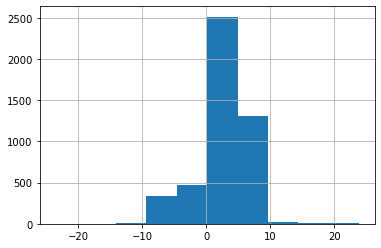

In [25]:
df[df['last_residual'].abs() > 4]['residual_one_month'].hist()

In [41]:
df['residual_diff'] = df['residual_mean_max'] - df['last_residual'].abs()

In [40]:
df[df['last_residual'].abs() > 5][['return_one_month', 'return_two_month', 'return_three_month']].mean()

return_one_month     -0.000979
return_two_month      0.060180
return_three_month    0.030309
dtype: float64

In [39]:
df[df['last_residual'].abs() > 5][['subindustry', 'return_one_month', 'return_two_month', 'return_three_month']].groupby('subindustry').mean()

,return_one_month,return_two_month,return_three_month
subindustry,,,
automobiles_and_components,0.020000,0.040000,0.040000
banks,-0.010714,-0.022143,-0.007857
capital_goods,0.006512,0.009535,-0.021395
chemicals,0.040000,0.035000,0.055000
commercial_and_professional_services,0.010000,0.000000,-0.040000
consumer_services,-0.040000,-0.030000,-0.025000
consumer_staples,-0.010000,-0.020000,-0.030000
diversified_financials,0.003455,0.000182,-0.005818
energy,-0.008235,0.065294,-0.012353


In [ ]:
df[['subindustry', 'return_one_month']].groupby('subindustry').mean()

In [44]:
pd.set_option('display.max_rows', 100)

In [26]:
df

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry
0,ABC,AMED,2021-10-06,0.54,-2.93,2.93,-83.26,3.74,0.01,-2.838965,-0.01,-3.040186,-0.07,-3.736888,2017-11-14,health_care_equipment_and_services
1,ABC,CAH,2021-10-06,0.92,-2.21,0.29,21.61,3.74,-0.03,-2.959616,-0.02,-2.739765,0.01,-2.038398,2017-11-14,health_care_equipment_and_services
2,ABC,PHG,2021-10-06,0.69,-2.27,0.33,14.11,3.74,0.01,-2.062742,-0.11,-4.361172,-0.14,-4.842980,2017-11-14,health_care_equipment_and_services
3,ABMD,AMEH,2021-10-06,0.54,2.70,0.14,-12.49,3.74,0.12,1.808040,0.04,2.441285,0.18,1.347642,2017-11-14,health_care_equipment_and_services
4,ABT,ADUS,2021-10-06,0.54,-2.47,0.60,31.22,3.74,0.13,-0.707720,0.04,-1.991751,0.02,-2.221983,2017-11-14,health_care_equipment_and_services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100472,KFY,RHI,2021-06-14,0.85,2.34,0.85,22.70,3.05,0.03,1.364591,-0.07,4.573430,-0.04,3.816241,2017-07-24,commercial_and_professional_services
100473,LDOS,RELX,2021-06-14,0.92,2.01,0.10,13.48,3.05,-0.04,3.270891,-0.11,5.556032,-0.11,5.594028,2017-07-24,commercial_and_professional_services
100474,NLSN,RHI,2021-06-14,0.54,2.81,1.78,22.55,3.05,0.00,2.771807,-0.12,4.897370,-0.16,5.607962,2017-07-24,commercial_and_professional_services
100475,VRSK,WCN,2021-06-14,0.77,3.62,0.37,34.24,3.05,0.02,3.126240,0.01,3.386326,0.01,3.252804,2017-07-24,commercial_and_professional_services


In [94]:
def assign_labels(df):
    def label_one_example(example):
        success_one_month = example['return_one_month'] >= 0.035 and (np.abs(example['last_residual']) - np.abs(example['residual_one_month'])) >= 1
        success_two_month = example['return_two_month'] >= 0.065 and (np.abs(example['last_residual']) - np.abs(example['residual_two_month'])) >= 2
        success_three_month = example['return_three_month'] >= 0.095 and (np.abs(example['last_residual']) - np.abs(example['residual_three_month'])) >= 2
        return int(any([success_one_month, success_two_month, success_three_month]))
    df_copy = df.copy()
    df_copy['label'] = df_copy.apply(label_one_example, axis=1)
    return df_copy

In [95]:
def transform_features(df):
    def industry_mappings(example):
        mappings = {
            'chemicals':'materials',
            'construction_materials':'materials',
            'containers_and_packaging':'materials',
            'metals_and_mining':'materials',
            'paper_and_forest_products':'materials',
            #
            'capital_goods':'industrials',
            'commercial_and_professional_services':'industrials',
            'transportation':'industrials',
            #
            'automobiles_and_components':'consumer_discretionary',
            'consumer_durables_and_apparel':'consumer_discretionary',
            'consumer_services':'consumer_discretionary',
            'retailing':'consumer_discretionary',
            #
            'health_care_equipment_and_services':'health_care',
            'pharmaceuticals_biotechnology_and_life_sciences':'health_care',
            #
            'banks':'financials',
            'diversified_financials':'financials',
            'insurance':'financials',
            #
            'software_and_services':'information_technology',
            'technology_hardware_and_equipment':'information_technology',
            'semiconductors_and_semiconductor_equipment':'information_technology',
            #
            'telecommunication_services':'communication_services',
            'media_and_entertainment':'communication_services',
            #
            'energy':'energy',
            'utilities':'utilities',
            'real_estate':'real_estate',
            'consumer_staples':'consumer_staples'
        }
        return mappings[example['subindustry']]
    
    df_copy = df.copy()
    # Select features
    df_copy = df_copy[['adf_pass_rate', 'last_residual', 'residual_mean_max', 'label', 'subindustry']]
    
    # Industry transform
    df_copy.loc[:, 'industry'] = df_copy.apply(industry_mappings, axis=1)
    df_copy = df_copy.drop(columns='subindustry')
    df_copy['industry'] = df_copy['industry'].astype('category')
    
    # Residual transform
    df_copy.loc[:, 'last_residual'] = df_copy['last_residual'].abs()
    
    return df_copy

In [96]:
df = pd.read_csv('data/eda.csv')

In [97]:
df = df[df['beta'] > 0]

In [98]:
df = assign_labels(df)

In [99]:
df = transform_features(df)

In [100]:
df

,adf_pass_rate,last_residual,residual_mean_max,label,industry
0,0.54,2.93,3.74,0,health_care
1,0.92,2.21,3.74,0,health_care
2,0.69,2.27,3.74,0,health_care
3,0.54,2.70,3.74,0,health_care
4,0.54,2.47,3.74,1,health_care
...,...,...,...,...,...
100472,0.85,2.34,3.05,0,industrials
100473,0.92,2.01,3.05,0,industrials
100474,0.54,2.81,3.05,0,industrials
100475,0.77,3.62,3.05,0,industrials


In [48]:
df

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry,label
0,ABC,AMED,2021-10-06,0.54,-2.93,2.93,-83.26,3.74,0.01,-2.838965,-0.01,-3.040186,-0.07,-3.736888,2017-11-14,health_care_equipment_and_services,0
1,ABC,CAH,2021-10-06,0.92,-2.21,0.29,21.61,3.74,-0.03,-2.959616,-0.02,-2.739765,0.01,-2.038398,2017-11-14,health_care_equipment_and_services,0
2,ABC,PHG,2021-10-06,0.69,-2.27,0.33,14.11,3.74,0.01,-2.062742,-0.11,-4.361172,-0.14,-4.842980,2017-11-14,health_care_equipment_and_services,0
3,ABMD,AMEH,2021-10-06,0.54,2.70,0.14,-12.49,3.74,0.12,1.808040,0.04,2.441285,0.18,1.347642,2017-11-14,health_care_equipment_and_services,0
4,ABT,ADUS,2021-10-06,0.54,-2.47,0.60,31.22,3.74,0.13,-0.707720,0.04,-1.991751,0.02,-2.221983,2017-11-14,health_care_equipment_and_services,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100472,KFY,RHI,2021-06-14,0.85,2.34,0.85,22.70,3.05,0.03,1.364591,-0.07,4.573430,-0.04,3.816241,2017-07-24,commercial_and_professional_services,0
100473,LDOS,RELX,2021-06-14,0.92,2.01,0.10,13.48,3.05,-0.04,3.270891,-0.11,5.556032,-0.11,5.594028,2017-07-24,commercial_and_professional_services,0
100474,NLSN,RHI,2021-06-14,0.54,2.81,1.78,22.55,3.05,0.00,2.771807,-0.12,4.897370,-0.16,5.607962,2017-07-24,commercial_and_professional_services,0
100475,VRSK,WCN,2021-06-14,0.77,3.62,0.37,34.24,3.05,0.02,3.126240,0.01,3.386326,0.01,3.252804,2017-07-24,commercial_and_professional_services,0


array([[<AxesSubplot:title={'center':'adf_pass_rate'}>]], dtype=object)

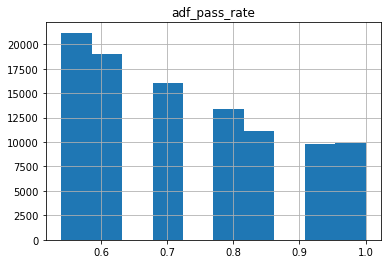

In [67]:
df[['adf_pass_rate']].abs(

In [72]:
df[df['beta'] < 0

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry,label
227,AYX,MIME,2021-10-06,0.77,2.42,-0.02,46.77,4.02,-0.25,4.498332,-0.18,3.876035,-0.24,4.412475,2017-11-14,software_and_services,0
228,AYX,PRGS,2021-10-06,0.62,2.06,-0.01,40.73,4.02,-0.06,2.708405,0.02,1.839296,0.07,1.347229,2017-11-14,software_and_services,0
293,CTXS,MIME,2021-10-06,0.85,2.44,-0.04,49.52,4.02,-0.25,4.450572,-0.17,3.790526,-0.25,4.428215,2017-11-14,software_and_services,0
320,EPAY,MIME,2021-10-06,0.62,2.37,-0.13,50.79,4.02,-0.28,4.594093,-0.20,3.953448,-0.30,4.708927,2017-11-14,software_and_services,0
1091,DINO,HESM,2021-10-06,0.62,2.04,-0.01,17.84,3.10,0.03,1.845883,0.01,1.976122,-0.11,2.769081,2017-11-14,energy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100280,CUK,CZR,2021-06-14,0.54,2.60,-0.18,58.53,3.36,0.13,1.963155,0.13,1.935340,0.03,2.457593,2017-07-24,consumer_services,0
100282,CUK,JACK,2021-06-14,0.54,2.36,-0.01,82.11,3.36,0.11,1.539421,0.14,1.284570,0.15,1.192287,2017-07-24,consumer_services,0
100283,CUK,MCRI,2021-06-14,0.62,2.24,-0.02,47.23,3.36,0.10,1.598162,0.05,1.905808,0.09,1.669533,2017-07-24,consumer_services,0
100394,GNW,PRI,2021-06-14,0.54,2.23,-1.42,125.46,3.06,0.08,1.466354,0.05,1.743754,0.06,1.704487,2017-07-24,insurance,0
